In [2]:
! pip install segmentation-models-pytorch
! pip install -U git+https://github.com/albumentations-team/albumentations
! pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 914.6 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.5 MB/s eta 0:00:0000:0100:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=5f41884cfa5ed6bf2246d7d7dccc630175dad7be5aed5578348650243416ad2e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=ec0115826c00f49cb570c955b4063b01d78029adf52ff2e0c637653763262954
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built e

In [1]:
import sys
sys.path.append('/kaggle/input/rucode-2024-2/segm_data-20240424T073630Z-001/segm_data')

In [3]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [4]:
def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

In [5]:
import os

images_path = '/kaggle/input/rucode-2024-2/segm_data-20240424T073630Z-001/segm_data/segm_train/train/images'
masks_path = '/kaggle/input/rucode-2024-2/segm_data-20240424T073630Z-001/segm_data/segm_train/train/gt'

images_list = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.tif')])
masks_list = sorted([os.path.join(masks_path, file) for file in os.listdir(masks_path) if file.endswith('.tif')])

df = pd.DataFrame({'images': images_list, 
                   'masks': masks_list})

df.head()

,images,masks
0,/kaggle/input/rucode-2024-2/segm_data-20240424...,/kaggle/input/rucode-2024-2/segm_data-20240424...
1,/kaggle/input/rucode-2024-2/segm_data-20240424...,/kaggle/input/rucode-2024-2/segm_data-20240424...
2,/kaggle/input/rucode-2024-2/segm_data-20240424...,/kaggle/input/rucode-2024-2/segm_data-20240424...
3,/kaggle/input/rucode-2024-2/segm_data-20240424...,/kaggle/input/rucode-2024-2/segm_data-20240424...
4,/kaggle/input/rucode-2024-2/segm_data-20240424...,/kaggle/input/rucode-2024-2/segm_data-20240424...


In [6]:
DATA_DIR = '/kaggle/working/'

DEVICE = torch.device('cuda' if torch.cuda.is_available else 'cpu')

EPOCHS = 50
LR = 0.003
IMAGE_SIZE = 256
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b6'
WEIGHTS = 'imagenet'

In [7]:
index = 4
row = df.iloc[index]

image_path = row.images
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask_path = row.masks
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

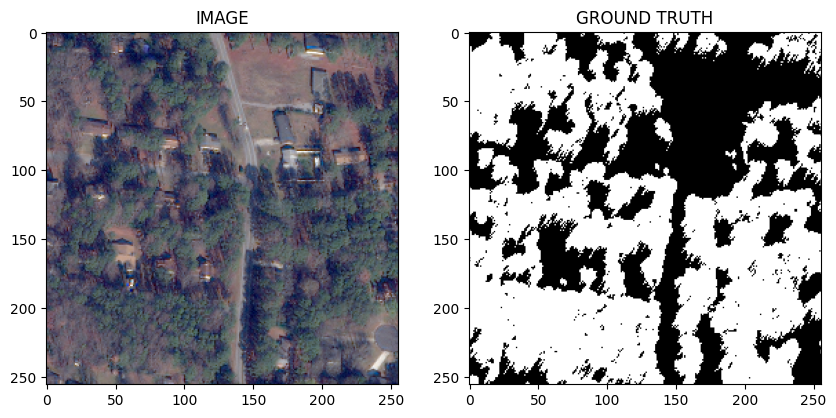

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, val_df = train_test_split(df, test_size=0.2)

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
    return A.Compose([A.Resize(IMAGE_SIZE, 
                               IMAGE_SIZE, 
                               always_apply=True),
                      A.HorizontalFlip(p=0.5),
                      A.VerticalFlip(p=0.5)],
                     is_check_shapes=False)


def get_val_augs():
    return A.Compose([A.Resize(IMAGE_SIZE, 
                               IMAGE_SIZE, 
                               always_apply=True)],
                     is_check_shapes=False)

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
    
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = df.iloc[index]
        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        image= np.transpose(image, (2, 0, 1))
        mask= np.transpose(mask, (2, 0, 1))

        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask) / 255.0

        return image, mask

In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(val_df, get_val_augs())

In [15]:
print(f"Size of Trainset: {len(trainset)}")
print(f"Size of Validset: {len(validset)}")

Size of Trainset: 2262
Size of Validset: 566


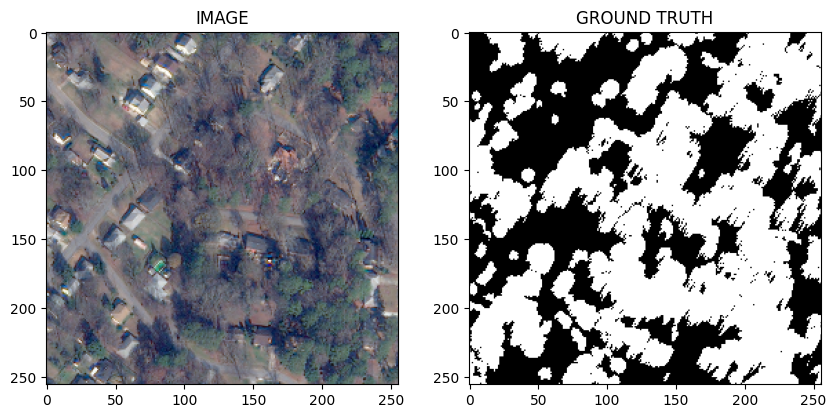

In [16]:
idx = 42

image, mask = trainset[idx]
show_image(image, mask)

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [19]:
print(f'Total number of batches in trainloader: {len(trainloader)}')
print(f'Total number of batches in validloader: {len(validloader)}')

Total number of batches in trainloader: 142
Total number of batches in validloader: 36


In [20]:
for image, mask in trainloader:
    break
    
print(f'One batch image shape {image.shape}')
print(f'One batch mask shape {mask.shape}')

One batch image shape torch.Size([16, 3, 256, 256])
One batch mask shape torch.Size([16, 1, 256, 256])


In [21]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):
    
    def __init__(self):
        super(SegmentationModel, self).__init__()
        
        self.arc = smp.UnetPlusPlus(encoder_name=ENCODER, # попробовать DeepLabV3Plus с b4
                                     encoder_weights=WEIGHTS,
                                     in_channels=3,
                                     classes=1,
                                     activation=None
                                    )
        
    def forward(self, images, masks=None):
        logits = self.arc(images)
        
        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            
            return logits, loss1 + loss2

        return logits

In [23]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b6_aa-80ba17e4.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b6_aa-80ba17e4.pth
100%|██████████| 165M/165M [00:00<00:00, 219MB/s] 


SegmentationModel(
  (arc): UnetPlusPlus(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
            (bn1): BatchNormAct2d(
              56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
 

In [24]:
! pip install torchsummary

In [25]:
from torchsummary import summary

summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 56, 128, 128]           1,512
          Identity-2         [-1, 56, 128, 128]               0
             Swish-3         [-1, 56, 128, 128]               0
    BatchNormAct2d-4         [-1, 56, 128, 128]             112
            Conv2d-5         [-1, 56, 128, 128]             504
          Identity-6         [-1, 56, 128, 128]               0
             Swish-7         [-1, 56, 128, 128]               0
    BatchNormAct2d-8         [-1, 56, 128, 128]             112
            Conv2d-9             [-1, 14, 1, 1]             798
            Swish-10             [-1, 14, 1, 1]               0
           Conv2d-11             [-1, 56, 1, 1]             840
          Sigmoid-12             [-1, 56, 1, 1]               0
    SqueezeExcite-13         [-1, 56, 128, 128]               0
           Conv2d-14         [-1, 32, 1

In [26]:
def train_net(dataloader, model, optimizer):
    model.train()
    
    total_loss = 0.0
    for images, masks in tqdm(dataloader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        logits, loss = model(images, masks)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [27]:
def eval_net(dataloader, model):
    model.eval()
    
    total_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            logits, loss = model(images, masks)
            total_loss += loss.item()
            
    return total_loss / len(dataloader)

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [29]:
best_valid_loss = np.Inf

for i in range (EPOCHS):
    train_loss = train_net(trainloader, model, optimizer)
    valid_loss = eval_net(validloader, model)
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("Model saved")
        best_valid_loss = valid_loss
    
    print(f'Epoch: {i+1}, Training Loss: {train_loss}, Validation Loss: {valid_loss}')

100%|██████████| 36/36 [00:11<00:00,  3.15it/s]


Model saved
Epoch: 1, Training Loss: 1.070246312399985, Validation Loss: 0.9759178509314855


100%|██████████| 36/36 [00:11<00:00,  3.04it/s]


Model saved
Epoch: 2, Training Loss: 1.040206103677481, Validation Loss: 0.9603076063924365


100%|██████████| 36/36 [00:11<00:00,  3.16it/s]


Model saved
Epoch: 3, Training Loss: 1.0314354493584432, Validation Loss: 0.9525400698184967


100%|██████████| 36/36 [00:11<00:00,  3.18it/s]


Model saved
Epoch: 4, Training Loss: 1.0245511053313672, Validation Loss: 0.9472795228163401


100%|██████████| 36/36 [00:11<00:00,  3.16it/s]


Model saved
Epoch: 5, Training Loss: 1.0222551658959456, Validation Loss: 0.9418812625937991


100%|██████████| 36/36 [00:11<00:00,  3.18it/s]


Model saved
Epoch: 6, Training Loss: 1.0182532630336116, Validation Loss: 0.9401564068264432


100%|██████████| 36/36 [00:11<00:00,  3.17it/s]


Model saved
Epoch: 7, Training Loss: 1.015753062258304, Validation Loss: 0.9395585490597619


100%|██████████| 36/36 [00:11<00:00,  3.16it/s]


Epoch: 8, Training Loss: 1.0153975734408474, Validation Loss: 0.9417285058233473


100%|██████████| 36/36 [00:11<00:00,  3.16it/s]


Model saved
Epoch: 9, Training Loss: 1.0151667107998485, Validation Loss: 0.9351923598183526


100%|██████████| 36/36 [00:11<00:00,  3.15it/s]


Epoch: 10, Training Loss: 1.0116278247933992, Validation Loss: 0.9352739436758889


100%|██████████| 36/36 [00:11<00:00,  3.16it/s]


Model saved
Epoch: 11, Training Loss: 1.0106553280017745, Validation Loss: 0.9325613164239459


100%|██████████| 36/36 [00:11<00:00,  3.15it/s]


Model saved
Epoch: 12, Training Loss: 1.0084395551345717, Validation Loss: 0.931154845489396


100%|██████████| 36/36 [00:11<00:00,  3.17it/s]


Model saved
Epoch: 13, Training Loss: 1.0069454790840686, Validation Loss: 0.9297781437635422


100%|██████████| 36/36 [00:11<00:00,  3.14it/s]


Epoch: 14, Training Loss: 1.0056235559389626, Validation Loss: 0.9302479475736618


100%|██████████| 36/36 [00:11<00:00,  3.16it/s]


Epoch: 15, Training Loss: 1.0048362369268713, Validation Loss: 0.934293571445677


100%|██████████| 36/36 [00:11<00:00,  3.16it/s]


Model saved
Epoch: 16, Training Loss: 1.0076735250546898, Validation Loss: 0.9283636344803704


100%|██████████| 36/36 [00:11<00:00,  3.16it/s]


Model saved
Epoch: 17, Training Loss: 1.0037995702783826, Validation Loss: 0.9262063172128465


100%|██████████| 36/36 [00:11<00:00,  3.19it/s]


Epoch: 18, Training Loss: 1.0026754804060494, Validation Loss: 0.9270847191413244


100%|██████████| 36/36 [00:11<00:00,  3.14it/s]


Model saved
Epoch: 19, Training Loss: 1.0019976559659125, Validation Loss: 0.9254066679212782


100%|██████████| 36/36 [00:11<00:00,  3.16it/s]


Epoch: 20, Training Loss: 1.0012689249616273, Validation Loss: 0.9289117323027717


100%|██████████| 36/36 [00:11<00:00,  3.11it/s]


Model saved
Epoch: 21, Training Loss: 1.001053211554675, Validation Loss: 0.9253045072158178


100%|██████████| 36/36 [00:11<00:00,  3.14it/s]


Model saved
Epoch: 22, Training Loss: 0.9999531192678801, Validation Loss: 0.9229855206277635


100%|██████████| 36/36 [00:11<00:00,  3.14it/s]


Model saved
Epoch: 23, Training Loss: 0.9992281609857586, Validation Loss: 0.9227867854966058


100%|██████████| 36/36 [00:11<00:00,  3.17it/s]


Epoch: 24, Training Loss: 0.9978134317297331, Validation Loss: 0.9228664222690794


100%|██████████| 36/36 [00:11<00:00,  3.11it/s]


Model saved
Epoch: 25, Training Loss: 0.9982750936293266, Validation Loss: 0.9213337782356474


100%|██████████| 36/36 [00:11<00:00,  3.15it/s]


Model saved
Epoch: 26, Training Loss: 0.9973975629873679, Validation Loss: 0.9211816423469119


100%|██████████| 36/36 [00:11<00:00,  3.14it/s]


Model saved
Epoch: 27, Training Loss: 0.9964966198927919, Validation Loss: 0.9197546078099145


100%|██████████| 36/36 [00:11<00:00,  3.12it/s]


Epoch: 28, Training Loss: 0.9958085174291906, Validation Loss: 0.9198743071821001


100%|██████████| 36/36 [00:11<00:00,  3.15it/s]


Epoch: 29, Training Loss: 0.9954154718090111, Validation Loss: 0.9221261408593919


100%|██████████| 36/36 [00:11<00:00,  3.18it/s]


Model saved
Epoch: 30, Training Loss: 0.996376375497227, Validation Loss: 0.9178106304672029


100%|██████████| 36/36 [00:11<00:00,  3.16it/s]


Epoch: 31, Training Loss: 0.9958870339561516, Validation Loss: 0.918556014696757


100%|██████████| 36/36 [00:11<00:00,  3.19it/s]


Epoch: 32, Training Loss: 0.9947023429501225, Validation Loss: 0.9179679916964637


100%|██████████| 36/36 [00:11<00:00,  3.15it/s]


Epoch: 33, Training Loss: 0.9932295973871795, Validation Loss: 0.9196433193153806


100%|██████████| 36/36 [00:11<00:00,  3.16it/s]


Epoch: 34, Training Loss: 0.9934929613496216, Validation Loss: 0.9182297107246187


100%|██████████| 36/36 [00:11<00:00,  3.12it/s]


Model saved
Epoch: 35, Training Loss: 0.9925130677055305, Validation Loss: 0.9169884009493722


100%|██████████| 36/36 [00:11<00:00,  3.15it/s]


Model saved
Epoch: 36, Training Loss: 0.992643158620512, Validation Loss: 0.9159157342380948


100%|██████████| 36/36 [00:11<00:00,  3.00it/s]


Model saved
Epoch: 37, Training Loss: 0.9911351653052048, Validation Loss: 0.9141951269573636


100%|██████████| 36/36 [00:11<00:00,  3.18it/s]


Epoch: 38, Training Loss: 0.9914775192737579, Validation Loss: 0.9152485993173387


100%|██████████| 36/36 [00:11<00:00,  3.16it/s]


Epoch: 39, Training Loss: 0.9899530003608112, Validation Loss: 0.9146356383959452


100%|██████████| 36/36 [00:11<00:00,  3.09it/s]


Epoch: 40, Training Loss: 0.9912985655623423, Validation Loss: 0.9200135899914635


100%|██████████| 36/36 [00:11<00:00,  3.14it/s]


Epoch: 41, Training Loss: 0.9964320537909656, Validation Loss: 0.9174347221851349


100%|██████████| 36/36 [00:11<00:00,  3.14it/s]


Epoch: 42, Training Loss: 0.9913751277285563, Validation Loss: 0.9144328534603119


100%|██████████| 36/36 [00:11<00:00,  3.18it/s]


Model saved
Epoch: 43, Training Loss: 0.9898286230967078, Validation Loss: 0.9130451712343428


100%|██████████| 36/36 [00:11<00:00,  3.06it/s]


Epoch: 44, Training Loss: 0.9890142284648519, Validation Loss: 0.9131065408388773


100%|██████████| 36/36 [00:11<00:00,  3.18it/s]


Model saved
Epoch: 45, Training Loss: 0.988340780768596, Validation Loss: 0.9130256076653799


100%|██████████| 36/36 [00:11<00:00,  3.17it/s]


Model saved
Epoch: 46, Training Loss: 0.9882166977499572, Validation Loss: 0.9119518945614496


100%|██████████| 36/36 [00:11<00:00,  3.14it/s]


Epoch: 47, Training Loss: 0.9880309734545963, Validation Loss: 0.9130729768011305


100%|██████████| 36/36 [00:11<00:00,  3.04it/s]


Epoch: 48, Training Loss: 0.9878102767635399, Validation Loss: 0.9122596830129623


100%|██████████| 36/36 [00:11<00:00,  3.09it/s]


Model saved
Epoch: 49, Training Loss: 0.9875837304222752, Validation Loss: 0.9112433890501658


100%|██████████| 36/36 [00:11<00:00,  3.17it/s]


Model saved
Epoch: 50, Training Loss: 0.9868294949262915, Validation Loss: 0.9101246893405914


In [30]:
model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))

<All keys matched successfully>

In [31]:
test_path = '/kaggle/input/rucode-2024-2/segm_data-20240424T073630Z-001/segm_data/segm_public_test/public_test/images'

test_list = sorted([os.path.join(test_path, file) for file in os.listdir(test_path) if file.endswith('.tif')])

test_df = pd.DataFrame({'images': test_list, 
                        'masks': test_list})

test_df.head()

,images,masks
0,/kaggle/input/rucode-2024-2/segm_data-20240424...,/kaggle/input/rucode-2024-2/segm_data-20240424...
1,/kaggle/input/rucode-2024-2/segm_data-20240424...,/kaggle/input/rucode-2024-2/segm_data-20240424...
2,/kaggle/input/rucode-2024-2/segm_data-20240424...,/kaggle/input/rucode-2024-2/segm_data-20240424...
3,/kaggle/input/rucode-2024-2/segm_data-20240424...,/kaggle/input/rucode-2024-2/segm_data-20240424...
4,/kaggle/input/rucode-2024-2/segm_data-20240424...,/kaggle/input/rucode-2024-2/segm_data-20240424...


In [32]:
test_path = '/kaggle/input/rucode-2024-2/segm_data-20240424T073630Z-001/segm_data/segm_public_test/public_test/images'

test_list = sorted([os.path.join(test_path, file) for file in os.listdir(test_path) if file.endswith('.tif')])

df = pd.DataFrame({'images': test_list, 
                   'masks': test_list})

df.head()

,images,masks
0,/kaggle/input/rucode-2024-2/segm_data-20240424...,/kaggle/input/rucode-2024-2/segm_data-20240424...
1,/kaggle/input/rucode-2024-2/segm_data-20240424...,/kaggle/input/rucode-2024-2/segm_data-20240424...
2,/kaggle/input/rucode-2024-2/segm_data-20240424...,/kaggle/input/rucode-2024-2/segm_data-20240424...
3,/kaggle/input/rucode-2024-2/segm_data-20240424...,/kaggle/input/rucode-2024-2/segm_data-20240424...
4,/kaggle/input/rucode-2024-2/segm_data-20240424...,/kaggle/input/rucode-2024-2/segm_data-20240424...


In [33]:
testset = SegmentationDataset(test_df, get_val_augs())

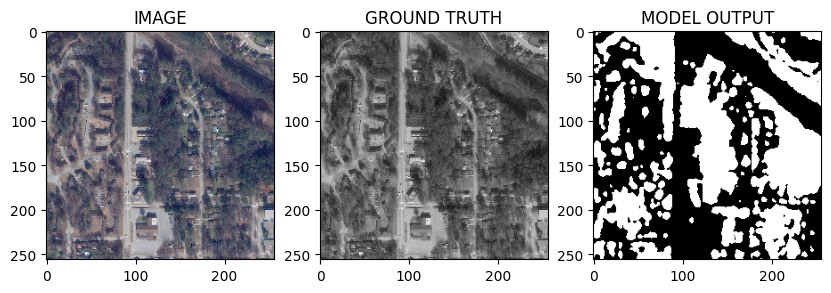

In [34]:
image, mask = testset[1]
logits_mask = model(image.to(DEVICE).unsqueeze(0))

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.23) * 1.0

show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

In [37]:
from torchvision.utils import save_image

for thold in (0.23,):

    if not os.path.exists(f'/kaggle/working/predictions_{thold}'):
        os.makedirs(f'/kaggle/working/predictions_{thold}')

    for index in range(707):
        curr_name = test_df.images[index].split('/')[-1]
        
        image, mask = testset[index]
        logits_mask = model(image.to(DEVICE).unsqueeze(0))

        pred_mask = torch.sigmoid(logits_mask)
        pred_mask = (pred_mask > thold) * 1.0

        save_image(pred_mask, f'/kaggle/working/predictions_{thold}/{curr_name}')
        
    path_to_dir = f'/kaggle/working/predictions_{thold}'

    files = os.listdir(path_to_dir)

    prefix = 't1_'
    filenames = [prefix + f'{i+1}.tif' for i in range(707)]

    assert len(filenames) == 707, f'Length of test set is {len(filenames)} not equal 707! Please check test images'

    def read_image_as_tensor(file_path):
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        tensor = np.array(image, dtype=np.bool_)

        return tensor

    tensor_list = []

    for filename in filenames:
        file_path = os.path.join(path_to_dir, filename)
        tensor = read_image_as_tensor(file_path)
        tensor_list.append(tensor)

    tensor_array = np.array(tensor_list)

    print('Размерность тензора:', tensor_array.shape)

    assert tensor_array.shape == (707, 256, 256), 'Please check path to images'

    output_file = f'solution_{thold}.npy'

    np.save(output_file, tensor_array)

Размерность тензора: (707, 256, 256)
Размерность тензора: (707, 256, 256)
Размерность тензора: (707, 256, 256)
Размерность тензора: (707, 256, 256)
Размерность тензора: (707, 256, 256)
Размерность тензора: (707, 256, 256)
Размерность тензора: (707, 256, 256)
Размерность тензора: (707, 256, 256)


In [36]:
# model: unet++, encoder: b6, lr: 0.003, bsize: 16, imsize: 256, thold: 0.23, epochs: 50 -> score: 82.72696